# Plot the Init decalib, GT, Pred, Keypoints and Feature Embeddings  

In [ ]:
import sys
sys.path.append('/workspace/')

import os
import numpy as np
import torch
from torch.utils.data import DataLoader

#from data.kitti_data import KittiDataset
#from data.nuscenes_data import NuscenesDataset

from models import HRegNet, Model_V2, Model_V6
from models.utils import calc_error_np, set_seed

import argparse
import datetime
from tqdm import tqdm

#MAN Dataset
from config import Config
import dataset

from losses import transformation_loss
from metrics.calibeval import CalibEval, MultiLayerCalibEval
from dataset.data_loader import load_dataset


def parse_args(args_list=None):
    parser = argparse.ArgumentParser(description='HRegNet')

    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--gpu', type=str, default='0')
    parser.add_argument('--root', type=str, default='')
    parser.add_argument('--npoints', type=int, default=16384)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--dataset', type=str, default='man')
    parser.add_argument('--use_fps', action='store_true')
    parser.add_argument('--data_list', type=str, default='')
    parser.add_argument('--use_weights', action='store_true')
    parser.add_argument('--pretrain_weights', type=str, default='')
    parser.add_argument('--voxel_size', type=float, default=0.3)
    parser.add_argument('--save_dir',type=str, default='')
    parser.add_argument('--augment', type=float, default=0.0)
    parser.add_argument('--freeze_detector', action='store_true')
    parser.add_argument('--freeze_feats', action='store_true')
    
    return parser.parse_args(args_list)


args = parse_args(['--use_fps', '--use_weights', '--freeze_detector', 
                   '--pretrain_weights', '/workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth'])

model_name = HRegNet

"""
 Change the model_name and --pretrain_weights 
    Name    - model_name - pretrain_weights
    HRegNet - HRegNet    - /workspace/ckpt/Baseline_Hregnet/best_val_loss.pth
    A1      - Model_V2   - /workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth
    A2      - Model_V6   - /workspace/ckpt/Adaption2_ptv3/best_val_RRE.pth """


/opt/conda/lib/python3.11/site-packages/spconv/pytorch/functional.py:51: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = amp.custom_fwd(cast_inputs=torch.float16)
/opt/conda/lib/python3.11/site-packages/spconv/pytorch/functional.py:100: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @_TORCH_CUSTOM_BWD
/opt/conda/lib/python3.11/site-packages/spconv/pytorch/functional.py:166: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @_TORCH_CUSTOM_BWD
/opt/conda/lib/python3.11/site-packages/spconv/pytorch/functional.py:246: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @_TORCH_CUSTOM_BWD
/opt/conda/lib/python3

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'\n Change the model_name and --pretrain_weights \n    Name    - model_name - pretrain_weights\n    HRegNet - HRegNet    - /workspace/ckpt/Baseline_Hregnet/best_val_loss.pth\n    A1      - Model_V2   - /workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth\n    A2      - Model_V6   - /workspace/ckpt/man_ckpt_Phil_T29_g_Full_Registration/best_val_RRE.pth '

# Load config, model and dataset

In [2]:
config = Config(args)
test_dataset = load_dataset(config=config, split='test')

# Initialize the Dataloader
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

#Initiailze the model
net = model_name(args).cuda()

#config.dataset_config.model = net.__class__.__name__


# Load the weights
checkpoint = torch.load(args.pretrain_weights)
if "net_state_dict" in checkpoint:
    net.load_state_dict(checkpoint["net_state_dict"],strict=False) 
else:
    raise KeyError("Key 'net_state_dict' not found in checkpoint file")

# Set the model to eval() mode
net.eval()

results_dir = os.path.join(args.save_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

#config.dataset_config.results_path = results_dir

# Initialize MultiLayer CalibEval
#calib_metrics = MultiLayerCalibEval(config=config, num_layers=3, translation_threshold=None,rotation_threshold=None)



with torch.no_grad():
    
    for i, data in enumerate(test_loader):
        
        #start_t = datetime.datetime.now()
        src_points = data['uncalibed_pcd'].contiguous().cuda()
        dst_points = data['pcd_left'].contiguous().cuda()
        igt = data['igt'].contiguous().cuda()

        ret_dict = net(src_points, dst_points)
        break


/tmp/ipykernel_65395/2705388791.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.pretrain_weights)


FileNotFoundError: [Errno 2] No such file or directory: ''

# Plot Keypoints

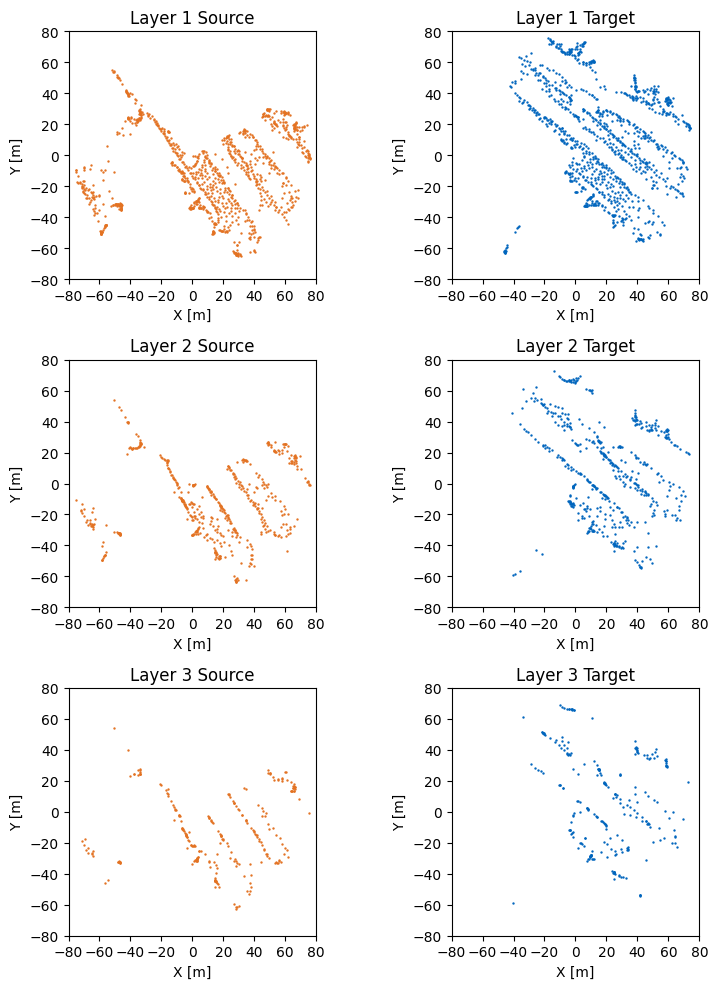

In [3]:
import matplotlib.pyplot as plt

# Process only the first sample
dst_cloud = dst_points[0].cpu().numpy()       # Calibrated left point cloud
calib_right = data['pcd_right'][0].cpu().numpy()  # Calibrated right point cloud
src_cloud = src_points[0].cpu().numpy()         # Decalibrated right point cloud

# Keypoints from three layers for src and dst (each shape: N×3)
src_xyz1 = ret_dict['src_feats']['xyz_1'][0].cpu().numpy()
src_xyz2 = ret_dict['src_feats']['xyz_2'][0].cpu().numpy()
src_xyz3 = ret_dict['src_feats']['xyz_3'][0].cpu().numpy()

dst_xyz1 = ret_dict['dst_feats']['xyz_1'][0].cpu().numpy()
dst_xyz2 = ret_dict['dst_feats']['xyz_2'][0].cpu().numpy()
dst_xyz3 = ret_dict['dst_feats']['xyz_3'][0].cpu().numpy()

# Create a 4x2 grid: 4 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
s = 0.5
left_color = "#0065BD"
right_color = "#E37222"

# ---------------- Rows 2-4: Keypoints -----------------
# Row 2: Layer 1 keypoints
axes[0, 0].scatter(src_xyz1[:, 0], src_xyz1[:, 1], s=s, color=right_color)
axes[0, 0].set_title('Layer 1 Source')
axes[0, 1].scatter(dst_xyz1[:, 0], dst_xyz1[:, 1], s=s, color=left_color)
axes[0, 1].set_title('Layer 1 Target')


# Row 3: Layer 2 keypoints
axes[1, 0].scatter(src_xyz2[:, 0], src_xyz2[:, 1], s=s, color=right_color)
axes[1, 0].set_title('Layer 2 Source')
axes[1, 1].scatter(dst_xyz2[:, 0], dst_xyz2[:, 1], s=s, color=left_color)
axes[1, 1].set_title('Layer 2 Target')


# Row 4: Layer 3 keypoints
axes[2, 0].scatter(src_xyz3[:, 0], src_xyz3[:, 1], s=s, color=right_color)
axes[2, 0].set_title('Layer 3 Source')
axes[2, 1].scatter(dst_xyz3[:, 0], dst_xyz3[:, 1], s=s, color=left_color)
axes[2, 1].set_title('Layer 3 Target')


# Set axis labels and ensure equal aspect ratio for all subplots
for ax in axes.flatten():
    ax.set_xlim(-80, 80)
    ax.set_ylim(-80, 80)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X [m]',fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.set_xticks([-80,-60,-40,-20, 0, 20, 40, 60, 80])
    

plt.tight_layout()
#plt.savefig("keypoints.pdf", dpi = 300, bbox_inches='tight')
plt.show()


# Plot Feature Embeddings

In [4]:
###############################
# Part 2: Feature Map Visualizations
###############################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def features_to_rgb_image(points, features, grid_resolution=256, xlim=(-80, 80), ylim=(-80, 80)):
    """
    Converts point features into an RGB image based on their (x,y) positions.
    
    points: (N,2) array of (x,y) positions.
    features: (N, C) array of feature vectors.
    grid_resolution: resolution of the output image (grid_resolution x grid_resolution).
    xlim, ylim: spatial limits.
    
    Returns:
        img: (grid_resolution, grid_resolution, 3) RGB image.
             Grid cells with no data are set to white.
    """
    # Ensure features has shape (N, C). If 1D, reshape to (N,1) then replicate to 3 channels.
    if features.ndim == 1:
        features = features.reshape(-1, 1)
    if features.shape[1] == 1:
        features = np.tile(features, (1, 3))
    
    # Reduce feature dimension to 3 using PCA.
    pca = PCA(n_components=3)
    feat_reduced = pca.fit_transform(features)  # (N, 3)
    
    # Normalize features to [0,1]
    feat_min = feat_reduced.min(axis=0)
    feat_max = feat_reduced.max(axis=0)
    feat_norm = (feat_reduced - feat_min) / (feat_max - feat_min + 1e-8)
    
    # Initialize an empty image and weight matrix.
    img = np.zeros((grid_resolution, grid_resolution, 3), dtype=np.float32)
    weight = np.zeros((grid_resolution, grid_resolution), dtype=np.float32)
    
    # Map points to grid indices.
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]
    grid_x = ((points[:, 0] - xlim[0]) / x_range * (grid_resolution - 1)).astype(int)
    grid_y = ((points[:, 1] - ylim[0]) / y_range * (grid_resolution - 1)).astype(int)
    
    # Clamp indices to valid range.
    grid_x = np.clip(grid_x, 0, grid_resolution - 1)
    grid_y = np.clip(grid_y, 0, grid_resolution - 1)
    
    # Accumulate features onto the grid.
    for i in range(points.shape[0]):
        gx = grid_x[i]
        gy = grid_y[i]
        img[gy, gx, :] += feat_norm[i]
        weight[gy, gx] += 1.0
    
    # Avoid division by zero and average overlapping points.
    mask = (weight == 0)
    weight[mask] = 1.0
    img = img / weight[:, :, None]
    img[mask, :] = 1.0  # cells with no points set to white.
    
    return np.clip(img, 0, 1)

def plot_feature_subplot(ax, points, features, title):
    """
    Plots a feature map on a given axis.
    """
    # Use the first two columns (x,y) from points.
    points_2d = points[:, :2]
    img = features_to_rgb_image(points_2d, features, grid_resolution=128, xlim=(-80, 80), ylim=(-80, 80))
    # Set origin='lower' so that the y-axis orientation matches scatter plots.
    ax.imshow(img, extent=(-80, 80, -80, 80), origin='lower')
    ax.set_title(title,fontsize=10)
    ax.set_xlabel('X [m]', fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-80, 80)
    ax.set_xticks(np.linspace(-80,80,9))
    ax.set_aspect('equal')

In [5]:
# Set up data for feature maps.
# For keypoint features, we use the keypoint positions:
left_points1  = dst_xyz1    # calibrated target keypoints (layer1)
left_points2  = dst_xyz2    # layer2
left_points3  = dst_xyz3    # layer3

right_points1 = src_xyz1    # decalibrated source keypoints (layer1)
right_points2 = src_xyz2    # layer2
right_points3 = src_xyz3    # layer3

# For registration features, we use the registration keypoints.
coarse_reg_points = ret_dict['src_xyz_corres_3'][0].cpu().numpy()
fine_reg1_points  = ret_dict['src_xyz_corres_2'][0].cpu().numpy()
fine_reg2_points  = ret_dict['src_xyz_corres_1'][0].cpu().numpy()

# For descriptors, we assume they are of shape (C, N) and need to be transposed.
left_feat1  = ret_dict['dst_feats']['desc_1'][0].cpu().numpy().T  # calibrated descriptor layer1
left_feat2  = ret_dict['dst_feats']['desc_2'][0].cpu().numpy().T  # layer2
left_feat3  = ret_dict['dst_feats']['desc_3'][0].cpu().numpy().T  # layer3

right_feat1 = ret_dict['src_feats']['desc_1'][0].cpu().numpy().T  # decalibrated descriptor layer1
right_feat2 = ret_dict['src_feats']['desc_2'][0].cpu().numpy().T  # layer2
right_feat3 = ret_dict['src_feats']['desc_3'][0].cpu().numpy().T  # layer3

# For registration features, we use the weights (reshape to (N,1)).
coarse_reg_feat = ret_dict['src_dst_weights_3'][0].cpu().numpy().reshape(-1, 1)
fine_reg1_feat  = ret_dict['src_dst_weights_2'][0].cpu().numpy().reshape(-1, 1)
fine_reg2_feat  = ret_dict['src_dst_weights_1'][0].cpu().numpy().reshape(-1, 1)

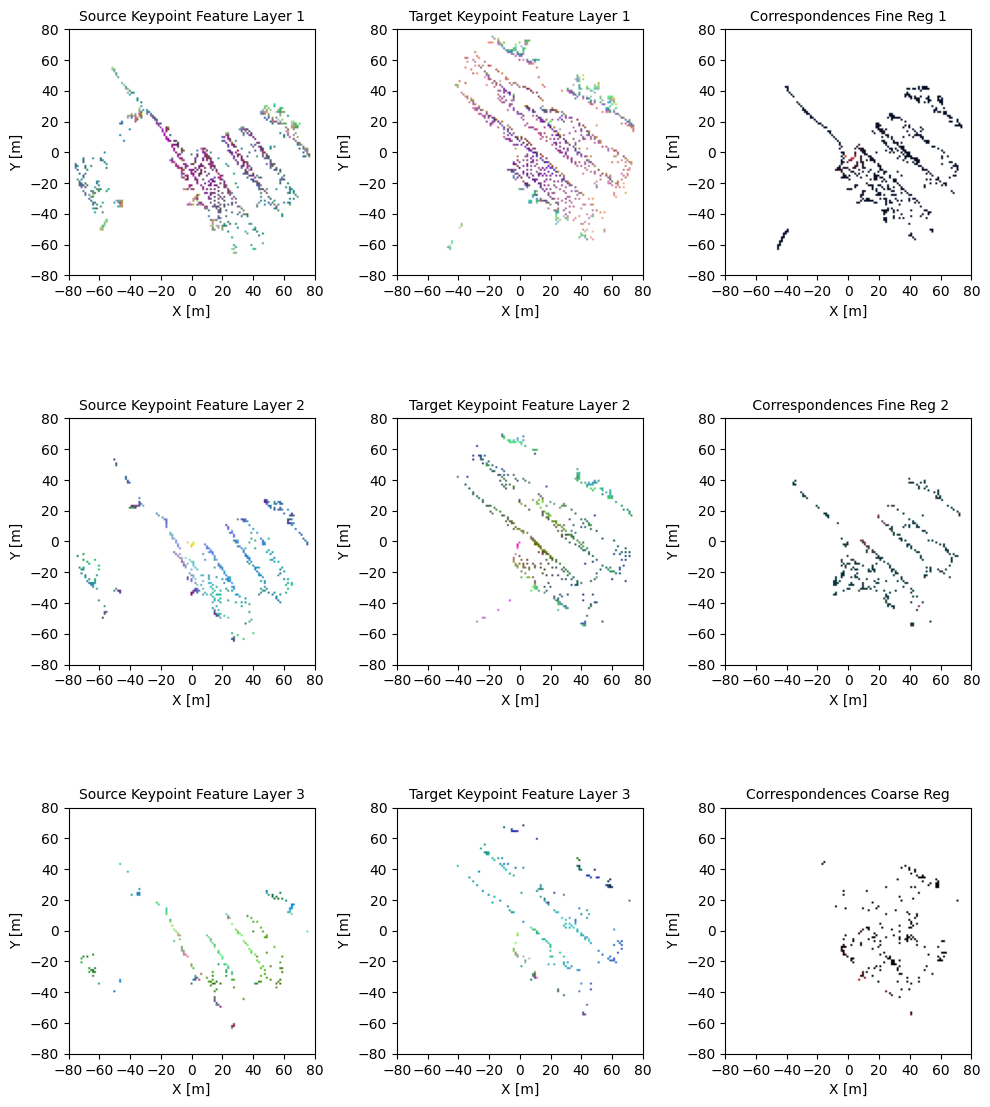

In [6]:
# Create a 3x3 grid for feature maps.
fig, axes = plt.subplots(3, 3, figsize=(10, 12))
plt.subplots_adjust(hspace=0.1, wspace=0.3)

# Row 0:
plot_feature_subplot(axes[0, 0], right_points1, right_feat1, "Source Keypoint Feature Layer 1")
plot_feature_subplot(axes[0, 1], left_points1, left_feat1, "Target Keypoint Feature Layer 1")
plot_feature_subplot(axes[0, 2], fine_reg2_points, fine_reg2_feat, "Correspondences Fine Reg 1")

# Row 1:
plot_feature_subplot(axes[1, 0], right_points2, right_feat2, "Source Keypoint Feature Layer 2")
plot_feature_subplot(axes[1, 1], left_points2, left_feat2, "Target Keypoint Feature Layer 2")
plot_feature_subplot(axes[1, 2], fine_reg1_points, fine_reg1_feat, " Correspondences Fine Reg 2")

# Row 2:
plot_feature_subplot(axes[2, 0], right_points3, right_feat3, "Source Keypoint Feature Layer 3")
plot_feature_subplot(axes[2, 1], left_points3, left_feat3, "Target Keypoint Feature Layer 3")
plot_feature_subplot(axes[2, 2], coarse_reg_points, coarse_reg_feat, "Correspondences Coarse Reg")

plt.tight_layout()
plt.savefig("feature_maps.pdf", dpi = 300, bbox_inches='tight')
plt.show()

# Plot GT, Initial decalib and Predicted Calibration

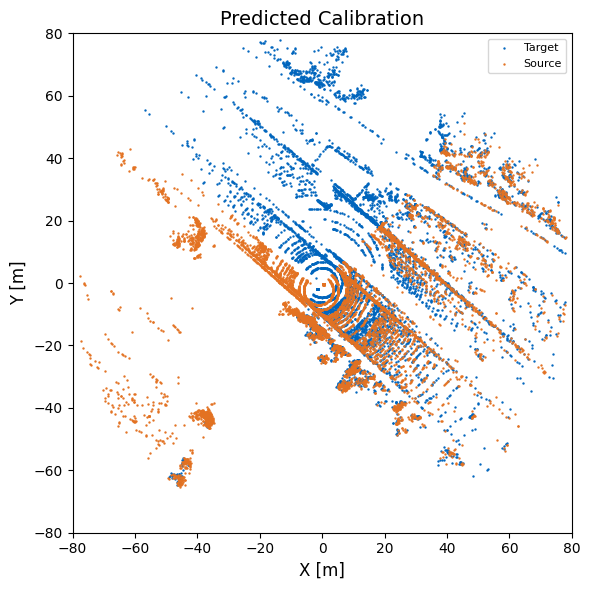

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Assume ret_dict is available from your network forward pass -----
# For sample 0, extract the final rotation and translation.
# Here we use ret_dict['rotation'][2] and ret_dict['translation'][2].
# They are torch tensors; convert them to numpy arrays.
R = ret_dict['rotation'][2][0].cpu().numpy()   # Shape: (3,3)
t = ret_dict['translation'][2][0].cpu().numpy()  # Shape: (3,)

# Build the 4x4 homogeneous transformation matrix.
T = np.eye(4)
T[:3, :3] = R
T[:3, 3] = t

# Get the source (decalibrated) point cloud for sample 0.
src_cloud = src_points[0].cpu().numpy()   # Shape: (N,3)

# Convert src_cloud to homogeneous coordinates.
N = src_cloud.shape[0]
src_cloud_h = np.hstack([src_cloud, np.ones((N, 1))])  # Shape: (N,4)

# Apply the transformation: calibrated_src = T * src_cloud_h
calibrated_src = (T @ src_cloud_h.T).T  # Shape: (N,4)
calibrated_src = calibrated_src[:, :3]   # Back to (N,3)

# Get the target (calibrated) point cloud for sample 0.
dst_cloud = dst_points[0].cpu().numpy()  # Shape: (N,3)

# Plot both clouds in one figure with the same color and marker style.
plt.figure(figsize=(6, 6))
s = 0.5
plot_color = 'blue'

plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Target')
plt.scatter(calibrated_src[:, 0], calibrated_src[:, 1], s=s, color=right_color, label='Source')

plt.title('Predicted Calibration',fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("output.svg", dpi=300, bbox_inches='tight')
plt.show()


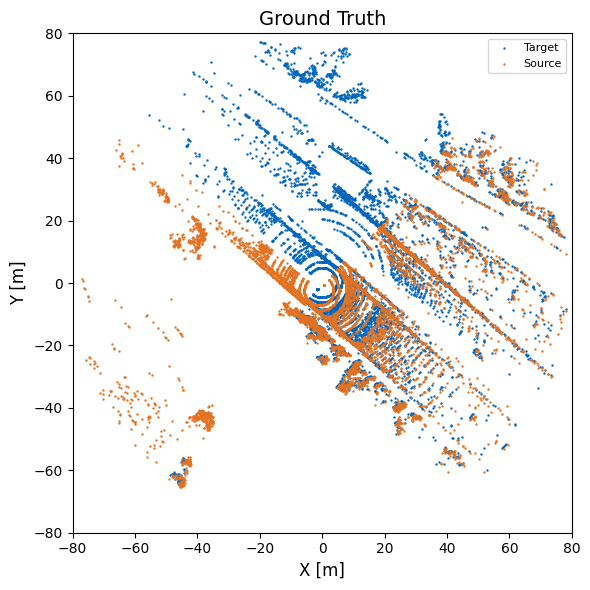

In [4]:
# Create a 4x2 grid: 4 rows, 2 columns
plt.figure(figsize=(6, 6))

# ---------------- First Row: Input Cloud Overlays -----------------
# Subplot (0,0): Overlay of calibrated left and calibrated right clouds
plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Target')
plt.scatter(calib_right[:, 0], calib_right[:, 1], s=s, color=right_color, label='Source')
plt.title('Ground Truth',fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("ground_truth.svg", dpi=300,bbox_inches='tight')
plt.show()

# # Subplot (0,1): Calibrated left and decalibrated right clouds
# axes[0, 1].scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Left Calibrated')
# axes[0, 1].scatter(src_cloud[:, 0], src_cloud[:, 1], s=s, color=right_color, label='Right Decalibrated')
# axes[0, 1].set_title('Initial Decalibration')
# axes[0, 1].legend()

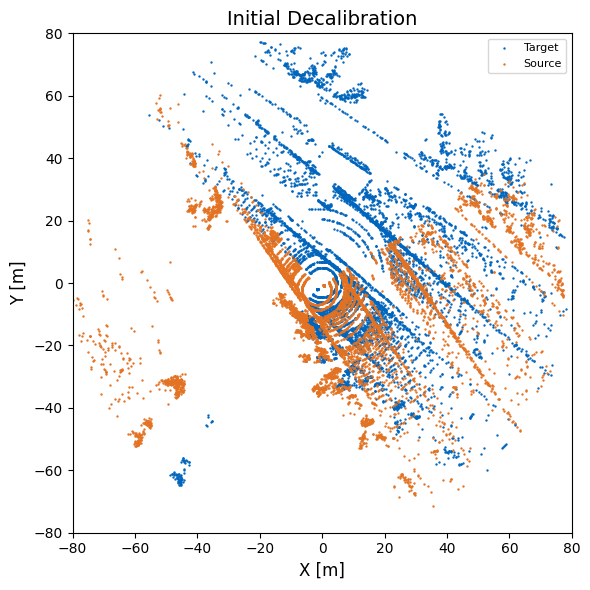

In [5]:
# Create a 4x2 grid: 4 rows, 2 columns
plt.figure(figsize=(6, 6))

# ---------------- First Row: Input Cloud Overlays -----------------
# Subplot (0,0): Overlay of calibrated left and calibrated right clouds
plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Target')
plt.scatter(src_cloud[:, 0], src_cloud[:, 1], s=s, color=right_color, label='Source')
plt.title('Initial Decalibration', fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("intial_decalib.pdf", dpi=300,bbox_inches='tight')
plt.show()